In [4]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 784), (5000, 784), (10000, 784))

In [5]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [6]:
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        #         dX = dout @ W.T # vanilla Backprop
        #         dX = dout @ W_fixed.T # fba backprop

        return dW, db

    def train_forward(self, X, train):
        caches = []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b'])
        y = np.tanh(y)
        X = y.copy() # pass to the next layer
        if train:
            caches.append(fc_cache)
        
        # Hidden layers
        fc_caches = []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y = np.tanh(y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
        if train:
            caches.append(fc_caches) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches

    def onehot(self, labels):
        # y = np.zeros([labels.size, np.max(labels) + 1])
        y = np.zeros([labels.size, self.C])
        y[range(labels.size), labels] = 1.
        return y

    def squared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]
        data_loss = 0.5 * np.sum((y_pred - self.onehot(y_train))**2)/ m
        return data_loss

    def dsquared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]
        grad_y = (y_pred - self.onehot(y_train))/ m
        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.squared_loss(y_pred=y_prob, y_train=y_train)
        dy = self.dsquared_loss(y_pred=y_prob, y_train=y_train)
        
        return loss, dy

    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        dy_prev = self.dy_prev.copy() # for temporal differencing
        self.dy_prev = dy.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        dy = dy - dy_prev # temporal diff instead of differentiable function
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy =  dy @ self.W_fixed[2].T
        dy_prev =  dy_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = dy - dy_prev # temporal diff instead of differentiable function
            dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy =  dy @ self.W_fixed[1][layer].T
            dy_prev =  dy_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache = caches[0]
        dy = dy - dy_prev # temporal diff instead of differentiable function
        dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
            # print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
            # format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [7]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 100 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, n_iter=n_iter, 
       print_after=print_after)

Iter-10, train loss-0.4521, acc-0.0800, valid loss-0.4519, acc-0.0822, test loss-0.4517, acc-0.0857
Iter-20, train loss-0.4516, acc-0.0900, valid loss-0.4518, acc-0.0816, test loss-0.4517, acc-0.0866
Iter-30, train loss-0.4510, acc-0.1100, valid loss-0.4517, acc-0.0830, test loss-0.4516, acc-0.0880
Iter-40, train loss-0.4518, acc-0.1300, valid loss-0.4516, acc-0.0836, test loss-0.4515, acc-0.0872
Iter-50, train loss-0.4513, acc-0.1100, valid loss-0.4517, acc-0.0796, test loss-0.4516, acc-0.0864
Iter-60, train loss-0.4531, acc-0.0800, valid loss-0.4515, acc-0.0828, test loss-0.4514, acc-0.0882
Iter-70, train loss-0.4519, acc-0.0800, valid loss-0.4516, acc-0.0834, test loss-0.4515, acc-0.0877
Iter-80, train loss-0.4516, acc-0.1000, valid loss-0.4514, acc-0.0874, test loss-0.4513, acc-0.0893
Iter-90, train loss-0.4524, acc-0.0900, valid loss-0.4513, acc-0.0866, test loss-0.4513, acc-0.0881
Iter-100, train loss-0.4515, acc-0.1000, valid loss-0.4511, acc-0.0894, test loss-0.4510, acc-0.0881

Iter-830, train loss-0.3558, acc-0.5000, valid loss-0.3438, acc-0.5358, test loss-0.3443, acc-0.5234
Iter-840, train loss-0.3258, acc-0.6100, valid loss-0.3426, acc-0.5348, test loss-0.3432, acc-0.5216
Iter-850, train loss-0.3467, acc-0.4900, valid loss-0.3414, acc-0.5376, test loss-0.3422, acc-0.5209
Iter-860, train loss-0.3304, acc-0.5600, valid loss-0.3400, acc-0.5422, test loss-0.3409, acc-0.5251
Iter-870, train loss-0.3482, acc-0.4800, valid loss-0.3389, acc-0.5436, test loss-0.3397, acc-0.5271
Iter-880, train loss-0.3488, acc-0.5300, valid loss-0.3372, acc-0.5476, test loss-0.3381, acc-0.5321
Iter-890, train loss-0.3325, acc-0.5800, valid loss-0.3359, acc-0.5510, test loss-0.3370, acc-0.5348
Iter-900, train loss-0.3340, acc-0.5900, valid loss-0.3345, acc-0.5540, test loss-0.3355, acc-0.5394
Iter-910, train loss-0.3215, acc-0.6000, valid loss-0.3332, acc-0.5566, test loss-0.3343, acc-0.5427
Iter-920, train loss-0.3270, acc-0.5800, valid loss-0.3322, acc-0.5554, test loss-0.3334, a

Iter-1640, train loss-0.2790, acc-0.6000, valid loss-0.2388, acc-0.7082, test loss-0.2430, acc-0.6914
Iter-1650, train loss-0.2260, acc-0.7200, valid loss-0.2380, acc-0.7102, test loss-0.2422, acc-0.6925
Iter-1660, train loss-0.2342, acc-0.7300, valid loss-0.2372, acc-0.7096, test loss-0.2412, acc-0.6936
Iter-1670, train loss-0.2366, acc-0.7500, valid loss-0.2360, acc-0.7110, test loss-0.2400, acc-0.6954
Iter-1680, train loss-0.2386, acc-0.7300, valid loss-0.2353, acc-0.7116, test loss-0.2394, acc-0.6947
Iter-1690, train loss-0.2801, acc-0.6300, valid loss-0.2342, acc-0.7138, test loss-0.2381, acc-0.6959
Iter-1700, train loss-0.2566, acc-0.6700, valid loss-0.2331, acc-0.7152, test loss-0.2369, acc-0.6983
Iter-1710, train loss-0.2367, acc-0.7000, valid loss-0.2320, acc-0.7170, test loss-0.2358, acc-0.6990
Iter-1720, train loss-0.2731, acc-0.6200, valid loss-0.2311, acc-0.7156, test loss-0.2349, acc-0.6987
Iter-1730, train loss-0.2371, acc-0.6900, valid loss-0.2299, acc-0.7194, test loss

Iter-2450, train loss-0.1843, acc-0.7800, valid loss-0.1859, acc-0.7706, test loss-0.1878, acc-0.7585
Iter-2460, train loss-0.2034, acc-0.7600, valid loss-0.1858, acc-0.7702, test loss-0.1878, acc-0.7566
Iter-2470, train loss-0.1827, acc-0.7800, valid loss-0.1856, acc-0.7670, test loss-0.1878, acc-0.7535
Iter-2480, train loss-0.1949, acc-0.7000, valid loss-0.1856, acc-0.7680, test loss-0.1878, acc-0.7555
Iter-2490, train loss-0.2030, acc-0.7200, valid loss-0.1852, acc-0.7706, test loss-0.1872, acc-0.7576
Iter-2500, train loss-0.1948, acc-0.7600, valid loss-0.1848, acc-0.7716, test loss-0.1868, acc-0.7589
Iter-2510, train loss-0.1717, acc-0.8000, valid loss-0.1850, acc-0.7716, test loss-0.1870, acc-0.7582
Iter-2520, train loss-0.2067, acc-0.7400, valid loss-0.1851, acc-0.7732, test loss-0.1872, acc-0.7585
Iter-2530, train loss-0.1956, acc-0.7300, valid loss-0.1850, acc-0.7730, test loss-0.1870, acc-0.7593
Iter-2540, train loss-0.1760, acc-0.8000, valid loss-0.1849, acc-0.7736, test loss

Iter-3260, train loss-0.1775, acc-0.7500, valid loss-0.1833, acc-0.7700, test loss-0.1864, acc-0.7627
Iter-3270, train loss-0.1773, acc-0.7900, valid loss-0.1836, acc-0.7706, test loss-0.1868, acc-0.7620
Iter-3280, train loss-0.1956, acc-0.7500, valid loss-0.1835, acc-0.7708, test loss-0.1866, acc-0.7625
Iter-3290, train loss-0.1886, acc-0.7800, valid loss-0.1836, acc-0.7714, test loss-0.1867, acc-0.7627
Iter-3300, train loss-0.2090, acc-0.7000, valid loss-0.1837, acc-0.7724, test loss-0.1869, acc-0.7618
Iter-3310, train loss-0.2212, acc-0.7300, valid loss-0.1838, acc-0.7712, test loss-0.1870, acc-0.7619
Iter-3320, train loss-0.1773, acc-0.8200, valid loss-0.1840, acc-0.7712, test loss-0.1870, acc-0.7630
Iter-3330, train loss-0.1988, acc-0.7500, valid loss-0.1844, acc-0.7714, test loss-0.1875, acc-0.7629
Iter-3340, train loss-0.1857, acc-0.7800, valid loss-0.1843, acc-0.7714, test loss-0.1875, acc-0.7616
Iter-3350, train loss-0.1941, acc-0.7600, valid loss-0.1846, acc-0.7704, test loss

Iter-4070, train loss-0.2233, acc-0.7400, valid loss-0.2109, acc-0.7438, test loss-0.2155, acc-0.7339
Iter-4080, train loss-0.1723, acc-0.8000, valid loss-0.2109, acc-0.7446, test loss-0.2154, acc-0.7354
Iter-4090, train loss-0.1706, acc-0.8200, valid loss-0.2110, acc-0.7428, test loss-0.2157, acc-0.7337
Iter-4100, train loss-0.1686, acc-0.8300, valid loss-0.2117, acc-0.7410, test loss-0.2165, acc-0.7325
Iter-4110, train loss-0.1929, acc-0.7800, valid loss-0.2123, acc-0.7422, test loss-0.2166, acc-0.7334
Iter-4120, train loss-0.2652, acc-0.6200, valid loss-0.2125, acc-0.7406, test loss-0.2170, acc-0.7317
Iter-4130, train loss-0.2006, acc-0.7200, valid loss-0.2126, acc-0.7398, test loss-0.2173, acc-0.7296
Iter-4140, train loss-0.2132, acc-0.7300, valid loss-0.2121, acc-0.7400, test loss-0.2165, acc-0.7305
Iter-4150, train loss-0.2299, acc-0.6800, valid loss-0.2122, acc-0.7388, test loss-0.2168, acc-0.7279
Iter-4160, train loss-0.2211, acc-0.7300, valid loss-0.2121, acc-0.7390, test loss

Iter-4880, train loss-0.2770, acc-0.6700, valid loss-0.2232, acc-0.7284, test loss-0.2286, acc-0.7166
Iter-4890, train loss-0.2470, acc-0.7300, valid loss-0.2234, acc-0.7300, test loss-0.2289, acc-0.7166
Iter-4900, train loss-0.2378, acc-0.7200, valid loss-0.2233, acc-0.7300, test loss-0.2286, acc-0.7181
Iter-4910, train loss-0.2046, acc-0.7800, valid loss-0.2234, acc-0.7304, test loss-0.2287, acc-0.7178
Iter-4920, train loss-0.2328, acc-0.7000, valid loss-0.2235, acc-0.7304, test loss-0.2287, acc-0.7195
Iter-4930, train loss-0.2427, acc-0.6800, valid loss-0.2232, acc-0.7290, test loss-0.2284, acc-0.7182
Iter-4940, train loss-0.2226, acc-0.7300, valid loss-0.2238, acc-0.7286, test loss-0.2291, acc-0.7154
Iter-4950, train loss-0.2333, acc-0.7200, valid loss-0.2236, acc-0.7308, test loss-0.2287, acc-0.7174
Iter-4960, train loss-0.2274, acc-0.7400, valid loss-0.2236, acc-0.7296, test loss-0.2288, acc-0.7171
Iter-4970, train loss-0.2397, acc-0.6700, valid loss-0.2237, acc-0.7296, test loss

Iter-5690, train loss-0.2841, acc-0.6400, valid loss-0.2351, acc-0.7206, test loss-0.2410, acc-0.7073
Iter-5700, train loss-0.2345, acc-0.7500, valid loss-0.2349, acc-0.7202, test loss-0.2409, acc-0.7074
Iter-5710, train loss-0.2416, acc-0.6900, valid loss-0.2349, acc-0.7194, test loss-0.2408, acc-0.7068
Iter-5720, train loss-0.1985, acc-0.7500, valid loss-0.2348, acc-0.7190, test loss-0.2407, acc-0.7063
Iter-5730, train loss-0.2540, acc-0.7100, valid loss-0.2350, acc-0.7186, test loss-0.2408, acc-0.7062
Iter-5740, train loss-0.2157, acc-0.7600, valid loss-0.2346, acc-0.7180, test loss-0.2404, acc-0.7060
Iter-5750, train loss-0.2321, acc-0.7200, valid loss-0.2348, acc-0.7196, test loss-0.2406, acc-0.7065
Iter-5760, train loss-0.2847, acc-0.6600, valid loss-0.2346, acc-0.7196, test loss-0.2404, acc-0.7067
Iter-5770, train loss-0.2546, acc-0.6700, valid loss-0.2350, acc-0.7190, test loss-0.2407, acc-0.7066
Iter-5780, train loss-0.2631, acc-0.6900, valid loss-0.2356, acc-0.7180, test loss

Iter-6500, train loss-0.2645, acc-0.6800, valid loss-0.2409, acc-0.7058, test loss-0.2466, acc-0.6966
Iter-6510, train loss-0.2501, acc-0.7200, valid loss-0.2411, acc-0.7044, test loss-0.2468, acc-0.6969
Iter-6520, train loss-0.2320, acc-0.7300, valid loss-0.2414, acc-0.7036, test loss-0.2471, acc-0.6954
Iter-6530, train loss-0.2415, acc-0.7000, valid loss-0.2410, acc-0.7042, test loss-0.2468, acc-0.6974
Iter-6540, train loss-0.2603, acc-0.6500, valid loss-0.2408, acc-0.7052, test loss-0.2466, acc-0.6959
Iter-6550, train loss-0.2454, acc-0.6600, valid loss-0.2409, acc-0.7052, test loss-0.2467, acc-0.6955
Iter-6560, train loss-0.2545, acc-0.7100, valid loss-0.2409, acc-0.7032, test loss-0.2467, acc-0.6960
Iter-6570, train loss-0.2143, acc-0.7600, valid loss-0.2414, acc-0.7038, test loss-0.2471, acc-0.6956
Iter-6580, train loss-0.2625, acc-0.6800, valid loss-0.2411, acc-0.7038, test loss-0.2469, acc-0.6960
Iter-6590, train loss-0.2228, acc-0.7000, valid loss-0.2414, acc-0.7026, test loss

Iter-7310, train loss-0.2308, acc-0.6800, valid loss-0.2454, acc-0.6838, test loss-0.2516, acc-0.6685
Iter-7320, train loss-0.2579, acc-0.6700, valid loss-0.2456, acc-0.6858, test loss-0.2518, acc-0.6691
Iter-7330, train loss-0.2376, acc-0.6900, valid loss-0.2455, acc-0.6854, test loss-0.2518, acc-0.6683
Iter-7340, train loss-0.2366, acc-0.6800, valid loss-0.2459, acc-0.6824, test loss-0.2522, acc-0.6681
Iter-7350, train loss-0.2694, acc-0.6000, valid loss-0.2459, acc-0.6836, test loss-0.2522, acc-0.6688
Iter-7360, train loss-0.2353, acc-0.6600, valid loss-0.2463, acc-0.6838, test loss-0.2524, acc-0.6687
Iter-7370, train loss-0.2354, acc-0.6700, valid loss-0.2465, acc-0.6828, test loss-0.2528, acc-0.6676
Iter-7380, train loss-0.2564, acc-0.6300, valid loss-0.2467, acc-0.6838, test loss-0.2529, acc-0.6687
Iter-7390, train loss-0.2718, acc-0.6800, valid loss-0.2467, acc-0.6802, test loss-0.2529, acc-0.6683
Iter-7400, train loss-0.2828, acc-0.6000, valid loss-0.2473, acc-0.6782, test loss

Iter-8120, train loss-0.2419, acc-0.6900, valid loss-0.2504, acc-0.6756, test loss-0.2587, acc-0.6565
Iter-8130, train loss-0.2235, acc-0.7500, valid loss-0.2508, acc-0.6736, test loss-0.2590, acc-0.6571
Iter-8140, train loss-0.3018, acc-0.5600, valid loss-0.2513, acc-0.6756, test loss-0.2595, acc-0.6574
Iter-8150, train loss-0.2603, acc-0.6300, valid loss-0.2515, acc-0.6740, test loss-0.2597, acc-0.6555
Iter-8160, train loss-0.2170, acc-0.7300, valid loss-0.2514, acc-0.6736, test loss-0.2596, acc-0.6566
Iter-8170, train loss-0.2802, acc-0.6400, valid loss-0.2510, acc-0.6752, test loss-0.2593, acc-0.6577
Iter-8180, train loss-0.2621, acc-0.6300, valid loss-0.2512, acc-0.6740, test loss-0.2596, acc-0.6567
Iter-8190, train loss-0.3162, acc-0.5700, valid loss-0.2512, acc-0.6736, test loss-0.2595, acc-0.6567
Iter-8200, train loss-0.2780, acc-0.6100, valid loss-0.2516, acc-0.6746, test loss-0.2600, acc-0.6566
Iter-8210, train loss-0.2836, acc-0.6700, valid loss-0.2520, acc-0.6738, test loss

Iter-8930, train loss-0.3077, acc-0.5900, valid loss-0.2519, acc-0.6714, test loss-0.2608, acc-0.6569
Iter-8940, train loss-0.2766, acc-0.6700, valid loss-0.2520, acc-0.6700, test loss-0.2610, acc-0.6564
Iter-8950, train loss-0.2534, acc-0.6800, valid loss-0.2520, acc-0.6718, test loss-0.2610, acc-0.6571
Iter-8960, train loss-0.3050, acc-0.6000, valid loss-0.2525, acc-0.6732, test loss-0.2613, acc-0.6568
Iter-8970, train loss-0.2394, acc-0.6900, valid loss-0.2528, acc-0.6696, test loss-0.2616, acc-0.6540
Iter-8980, train loss-0.2356, acc-0.7000, valid loss-0.2525, acc-0.6726, test loss-0.2614, acc-0.6555
Iter-8990, train loss-0.2490, acc-0.6700, valid loss-0.2525, acc-0.6730, test loss-0.2613, acc-0.6554
Iter-9000, train loss-0.2593, acc-0.6400, valid loss-0.2528, acc-0.6694, test loss-0.2616, acc-0.6523
Iter-9010, train loss-0.3322, acc-0.6000, valid loss-0.2526, acc-0.6720, test loss-0.2613, acc-0.6549
Iter-9020, train loss-0.2274, acc-0.6800, valid loss-0.2528, acc-0.6646, test loss

Iter-9740, train loss-0.2477, acc-0.6500, valid loss-0.2514, acc-0.6432, test loss-0.2599, acc-0.6273
Iter-9750, train loss-0.2400, acc-0.6500, valid loss-0.2514, acc-0.6462, test loss-0.2601, acc-0.6277
Iter-9760, train loss-0.2426, acc-0.6700, valid loss-0.2512, acc-0.6470, test loss-0.2598, acc-0.6295
Iter-9770, train loss-0.2221, acc-0.7000, valid loss-0.2515, acc-0.6422, test loss-0.2601, acc-0.6245
Iter-9780, train loss-0.2742, acc-0.6200, valid loss-0.2513, acc-0.6436, test loss-0.2599, acc-0.6265
Iter-9790, train loss-0.2422, acc-0.6700, valid loss-0.2513, acc-0.6436, test loss-0.2600, acc-0.6283
Iter-9800, train loss-0.2462, acc-0.6600, valid loss-0.2512, acc-0.6476, test loss-0.2599, acc-0.6324
Iter-9810, train loss-0.2311, acc-0.6900, valid loss-0.2514, acc-0.6418, test loss-0.2601, acc-0.6249
Iter-9820, train loss-0.2639, acc-0.6100, valid loss-0.2516, acc-0.6400, test loss-0.2602, acc-0.6232
Iter-9830, train loss-0.2300, acc-0.7200, valid loss-0.2514, acc-0.6418, test loss

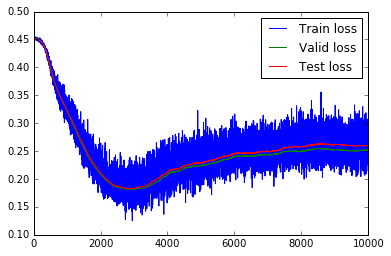

In [8]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

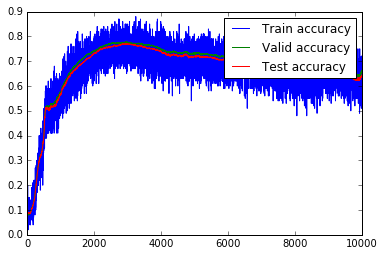

In [9]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()